In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import Audio
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import os

In [60]:
data_dir = r'C:\Users\sakth\OneDrive\Desktop\speechemotionrecognition\tess'
features = []
labels = []
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        emotion_label = folder.split('_')[-1]
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if file_path.endswith('.wav'):
                audio, sr = librosa.load(file_path, duration=3)
                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
                mfcc_mean = np.mean(mfcc, axis=1)
                features.append(mfcc_mean)
                labels.append(emotion_label)
features = np.array(features)
labels = np.array(labels)

In [16]:
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)


Features shape: (2800, 13)
Labels shape: (2800,)


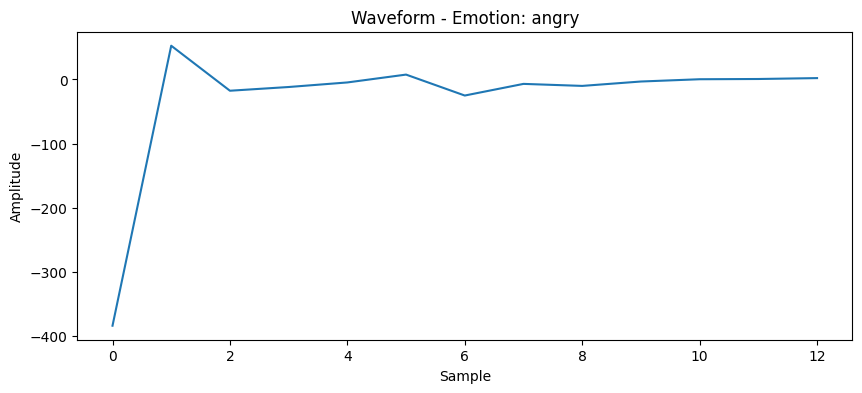

In [17]:
chosen_index = 0 
chosen_audio = features[chosen_index]
chosen_label = labels[chosen_index]

plt.figure(figsize=(10, 4))
plt.title(f'Waveform - Emotion: {chosen_label}')
plt.plot(chosen_audio)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()


In [18]:
chosen_audio, sr = librosa.load(r'C:\Users\sakth\OneDrive\Desktop\speechemotionrecognition\tess\OAF_happy\OAF_bar_happy.wav', duration=3)



In [19]:
print("Chosen Audio Shape:", chosen_audio.shape)
print("Sampling Rate (sr):", sr)


Chosen Audio Shape: (44108,)
Sampling Rate (sr): 22050


In [20]:
spectrogram = librosa.feature.melspectrogram(y=chosen_audio, sr=sr)
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)


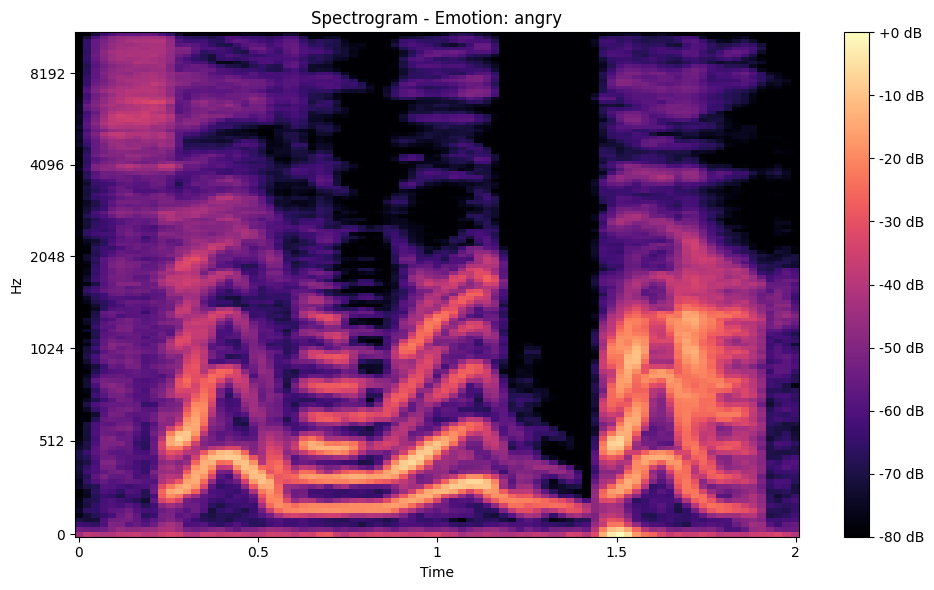

In [21]:
plt.figure(figsize=(10, 6))
librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Spectrogram - Emotion: {chosen_label}')
plt.tight_layout()
plt.show()


In [22]:
print("Chosen Audio Shape:", chosen_audio.shape)
print("Sampling Rate (sr):", sr)


Chosen Audio Shape: (44108,)
Sampling Rate (sr): 22050


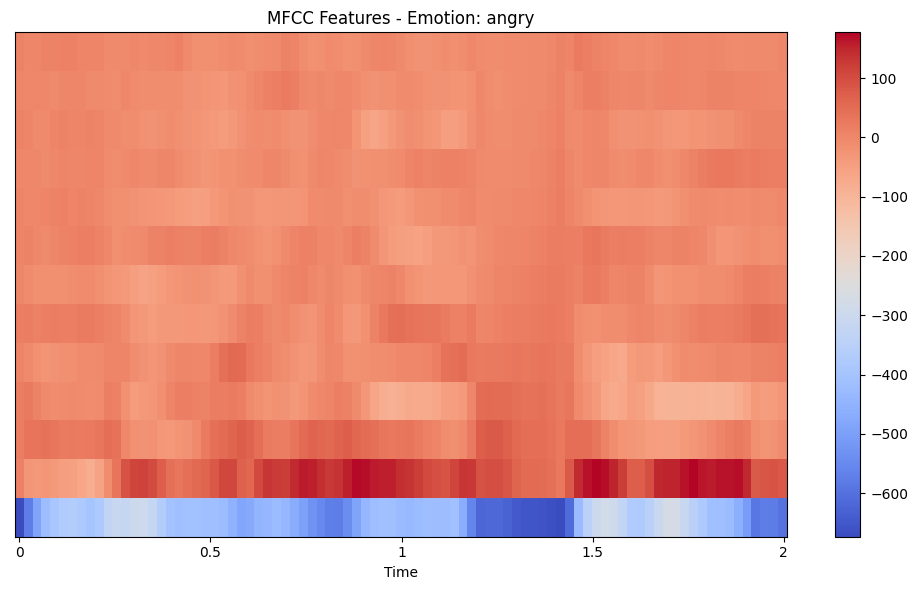

In [23]:
mfcc = librosa.feature.mfcc(y=chosen_audio, sr=sr, n_mfcc=13)
plt.figure(figsize=(10, 6))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title(f'MFCC Features - Emotion: {chosen_label}')
plt.tight_layout()
plt.show()


In [24]:
print("Shape of chosen_mfcc:", mfcc.shape)

Shape of chosen_mfcc: (13, 87)


In [25]:
augmented_features = []
augmented_labels = []
for feature, label in zip(features, labels):
    augmented_features.append(feature)
    augmented_labels.append(label)
    noise = np.random.randn(len(feature))
    augmented_features.append(feature + 0.005 * noise)
    augmented_labels.append(label)
    augmented_features.append(librosa.effects.time_stretch(feature, rate=1.2))
    augmented_labels.append(label)


In [26]:
max_length = max(len(feature) for feature in augmented_features)
padded_features = []
for feature in augmented_features:
    if len(feature) < max_length:
        padded_feature = np.pad(feature, (0, max_length - len(feature)))
    else:
        padded_feature = feature[:max_length]
    padded_features.append(padded_feature)
augmented_features = np.array(padded_features)
augmented_labels = np.array(augmented_labels)


In [27]:
print("Augmented Features shape:", augmented_features.shape)
print("Augmented Labels shape:", augmented_labels.shape)
for i in range(5):
    print(f"Length of feature {i + 1}: {len(augmented_features[i])}")


Augmented Features shape: (8400, 13)
Augmented Labels shape: (8400,)
Length of feature 1: 13
Length of feature 2: 13
Length of feature 3: 13
Length of feature 4: 13
Length of feature 5: 13


In [28]:
augmented_features = np.array(augmented_features)
augmented_labels = np.array(augmented_labels)
print('Original samples:', len(features))
print('Augmented samples:', len(augmented_features))


Original samples: 2800
Augmented samples: 8400


In [29]:
label_mapping = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}
encoded_labels = np.array([label_mapping.get(label, -1) for label in labels])
valid_indices = np.where(encoded_labels != -1)[0]
features = features[valid_indices]
encoded_labels = encoded_labels[valid_indices]

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

In [32]:
X_train = X_train.reshape((*X_train.shape, 1))
X_test = X_test.reshape((*X_test.shape, 1))

In [34]:
from keras.utils import to_categorical

num_classes = len(label_mapping)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


In [35]:
print("Training Data Shapes:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("\nTesting Data Shapes:")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


Training Data Shapes:
X_train shape: (1600, 13, 1)
y_train shape: (1600, 6)

Testing Data Shapes:
X_test shape: (400, 13, 1)
y_test shape: (400, 6)


In [38]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(13, 1, 1), padding='same'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 1, 32)         320       
                                                                 
 flatten (Flatten)           (None, 416)               0         
                                                                 
 dense (Dense)               (None, 32)                13344     
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                                 
Total params: 13862 (54.15 KB)
Trainable params: 13862 (54.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100


25/25 [==============================] - 2s 15ms/step - loss: 5.3073 - accuracy: 0.2144 - val_loss: 1.8381 - val_accuracy: 0.3550
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 1.3521 - accuracy: 0.4588 - val_loss: 0.9954 - val_accuracy: 0.6475
Epoch 3/100
25/25 [==============================] - 0s 4ms/step - loss: 0.9152 - accuracy: 0.6481 - val_loss: 0.7419 - val_accuracy: 0.7325
Epoch 4/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.7669 - val_loss: 0.5888 - val_accuracy: 0.8025
Epoch 5/100
25/25 [==============================] - 0s 3ms/step - loss: 0.5409 - accuracy: 0.8456 - val_loss: 0.4938 - val_accuracy: 0.8700
Epoch 6/100
25/25 [==============================] - 0s 3ms/step - loss: 0.4469 - accuracy: 0.8831 - val_loss: 0.4024 - val_accuracy: 0.8975
Epoch 7/100
25/25 [==============================] - 0s 3ms/step - loss: 0.3645 - accuracy: 0.9137 - val_loss: 0.3560 - val_accuracy: 0.9025
Epoch 8/10

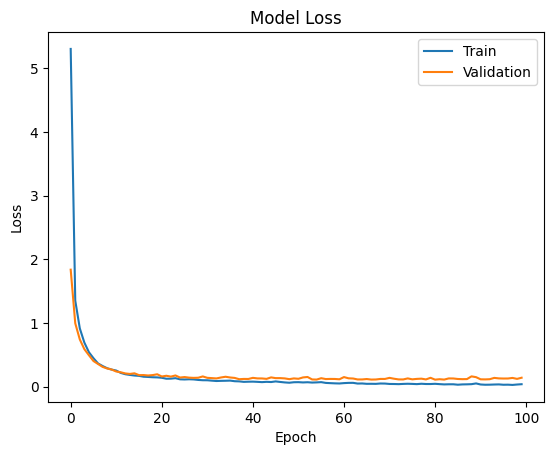

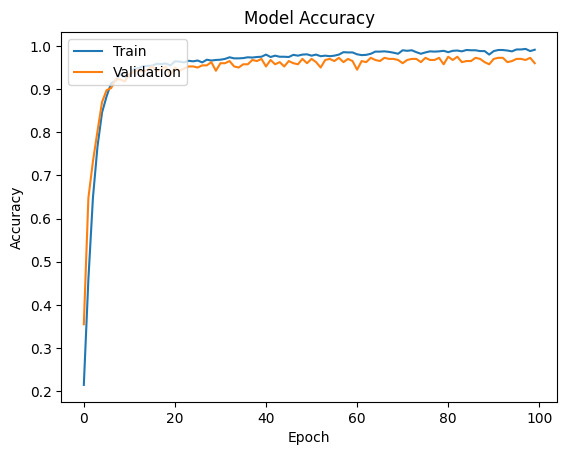

In [39]:

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [41]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

13/13 [==============================] - 0s 1ms/step


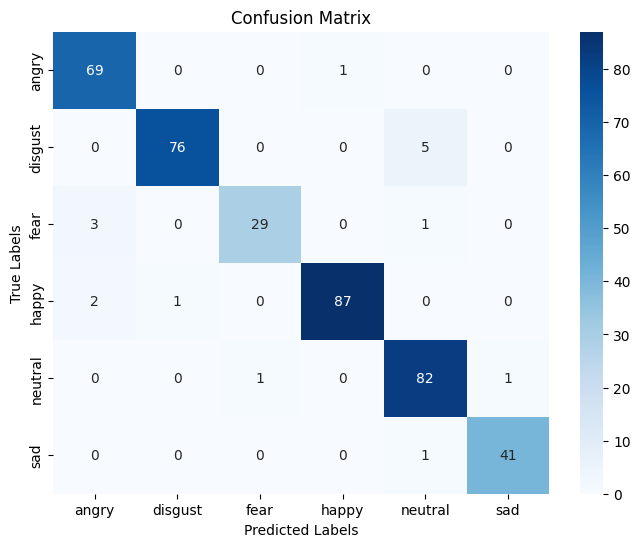

In [45]:

cm = confusion_matrix(y_true_labels, y_pred_labels)
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']  
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [46]:
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, labels=range(len(class_names)))
print(report)

              precision    recall  f1-score   support

       angry       0.93      0.99      0.96        70
     disgust       0.99      0.94      0.96        81
        fear       0.97      0.88      0.92        33
       happy       0.99      0.97      0.98        90
     neutral       0.92      0.98      0.95        84
         sad       0.98      0.98      0.98        42

    accuracy                           0.96       400
   macro avg       0.96      0.95      0.96       400
weighted avg       0.96      0.96      0.96       400



In [47]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, batch_size=16)

Epoch 1/500
100/100 [==============================] - 1s 3ms/step - loss: 0.1371 - accuracy: 0.9519 - val_loss: 0.2017 - val_accuracy: 0.9450
Epoch 2/500
100/100 [==============================] - 0s 2ms/step - loss: 0.1159 - accuracy: 0.9563 - val_loss: 0.1995 - val_accuracy: 0.9600
Epoch 3/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0835 - accuracy: 0.9675 - val_loss: 0.2999 - val_accuracy: 0.9450
Epoch 4/500
100/100 [==============================] - 0s 3ms/step - loss: 0.1305 - accuracy: 0.9613 - val_loss: 0.5131 - val_accuracy: 0.8975
Epoch 5/500
100/100 [==============================] - 0s 2ms/step - loss: 0.1008 - accuracy: 0.9706 - val_loss: 0.2823 - val_accuracy: 0.9475
Epoch 6/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0533 - accuracy: 0.9787 - val_loss: 0.1544 - val_accuracy: 0.9625
Epoch 7/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0772 - accuracy: 0.9731 - val_loss: 0.1862 - val_accuracy: 0.9650

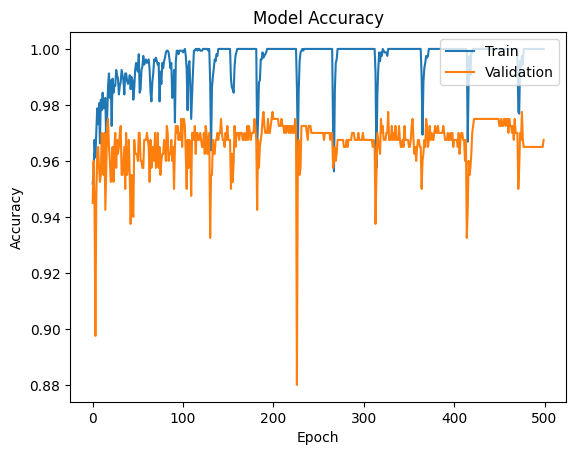

In [48]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

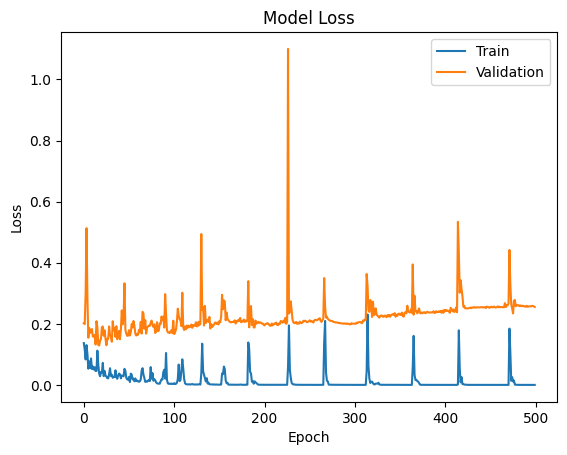

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [50]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true_labels, y_pred_labels)
print(f"accuracy:{accuracy*100}%")


accuracy:96.0%


In [55]:

model.save('emotion_detection_model.keras')


In [56]:
audio_file_path = r'C:\Users\sakth\OneDrive\Desktop\speechemotionrecognition\tess\YAF_happy\YAF_base_happy.wav'
audio, sr = librosa.load(audio_file_path, sr=None)
user_mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

In [57]:
num_frames, num_mfcc = user_mfcc.shape
print("Number of frames:", num_frames)
print("Number of MFCC coefficients:", num_mfcc)


Number of frames: 13
Number of MFCC coefficients: 90


In [58]:
print(user_mfcc.shape)


(13, 90)


In [59]:
import librosa
import numpy as np
def extract_mfcc(audio_file_path):
    audio, sr = librosa.load(audio_file_path, duration=3)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_reshaped = np.expand_dims(mfcc_mean.T, axis=0)
    mfcc_reshaped = np.expand_dims(mfcc_reshaped, axis=-1)
    mfcc_reshaped = np.expand_dims(mfcc_reshaped, axis=-1)
    return mfcc_reshaped
audio_file_path = r'C:\Users\sakth\OneDrive\Desktop\speechemotionrecognition\tess\YAF_happy\YAF_base_happy.wav'
mfcc_features = extract_mfcc(audio_file_path)
print(f"Extracted MFCC features shape: {mfcc_features.shape}")
predicted_emotion = model.predict(mfcc_features)
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
predicted_index = np.argmax(predicted_emotion, axis=1)
predicted_label = class_names[predicted_index[0]]
print(f"Predicted Emotion: {predicted_label}")



Extracted MFCC features shape: (1, 13, 1, 1)
1/1 [==============================] - 0s 20ms/step
Predicted Emotion: happy
